In [1]:
# Imports and Spark session
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import BooleanType
import os, math, json
import pandas as pd

spark = SparkSession.builder.appName("Weekly Meal Plan").getOrCreate()
print("Spark version:", spark.version)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/03 18:18:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/01/03 18:18:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Spark version: 4.0.1


In [ ]:
# User preferences and configuration
# Input paths
# Options: set to your dataset locations (Parquet directory or file)
input_path = "output/nutritional_profiles"
fallback_file = "output/nutritional_profiles/part-00000-c8bad44e-47d3-4d65-81e1-c1a23350546a-c000.snappy.parquet"
output_dir = "output/MealPlan"
write_outputs = True   # Options: True/False

# User profile
# Options: gender in {'male','female'}; age (years); weight_kg; height_cm; activity_level in {'sedentary','light','moderate','heavy'}
# goal in {'muscle_gain','weight_loss','maintenance'}; gym_training True/False
gender = 'male'            # 'male' or 'female'
age = 24                   # years
weight_kg = 90             # kg
height_cm = 178            # cm
activity_level = 'sedentary'  # sedentary|light|moderate|heavy
goal = 'weight_loss'         # 'muscle_gain' | 'weight_loss' | 'maintenance'
gym_training = False          # True/False

# Allergens and preferences
# Allergens: leave empty and list options below as comments; add any that apply
exclude_allergens = []
# Options for allergens: 'gluten', 'peanut', 'tree nut', 'soy', 'milk', 'egg', 'fish', 'shellfish', 'sesame'

# Dislikes: keywords to avoid entirely (in ingredients/description/name)
# Examples: 'tomato', 'pork', 'beef', 'alcohol', 'spicy'
dislikes = ['tomato']

# Likes: keywords to prefer (mild bonus in scoring)
# Examples: 'chicken', 'rice', 'lentil', 'tofu', 'quinoa', 'oats', 'yogurt'
likes = ['chicken', 'rice', 'lentil', 'tofu', 'quinoa']

# Pantry flags and items
# If pantry_available is True, foods matching these keywords get a bonus
pantry_available = True      # True/False
# Examples: staple items you have at home
pantry_items = ['rice', 'lentil', 'beans', 'oats', 'olive oil']

# Meal structure (percentage of daily calories)
# Options: adjust splits per meal, must sum to 1.0
meal_splits = { 'breakfast': 0.25, 'lunch': 0.35, 'dinner': 0.40 }

# Macro targets by goal (percent of calories)
# Options: tweak macro percentages to match your dietary approach
macro_targets_by_goal = {
    'weight_loss':   {'protein_pct': 0.30, 'carb_pct': 0.40, 'fat_pct': 0.30},
    'muscle_gain':   {'protein_pct': 0.30, 'carb_pct': 0.50, 'fat_pct': 0.20},
    'maintenance':   {'protein_pct': 0.25, 'carb_pct': 0.50, 'fat_pct': 0.25}
}

# Scoring weights
# Options: tune the influence of factors; higher means more impact
weights = {
    'like_bonus': 0.3,          # bonus if food matches a 'like' keyword
    'pantry_bonus': 0.3,        # bonus if food matches pantry items (when pantry_available=True)
    'macro_fit_weight': 1.0,    # weight for macro proportion fit
    'calorie_fit_weight': 0.7   # weight for closeness to meal calorie target
}

In [3]:
# Read dataset
path = input_path if os.path.exists(input_path) else fallback_file
print('Input path:', path)
df = spark.read.parquet(path)
df.printSchema()

Input path: output/nutritional_profiles


root
 |-- fdc_id: long (nullable = true)
 |-- food_description: string (nullable = true)
 |-- food_type: string (nullable = true)
 |-- total_nutrients: long (nullable = true)
 |-- energy: double (nullable = true)
 |-- protein: double (nullable = true)
 |-- carbs: double (nullable = true)
 |-- total_fat: double (nullable = true)
 |-- water: double (nullable = true)
 |-- ash: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- caffeine: double (nullable = true)
 |-- fiber: double (nullable = true)
 |-- sugars: double (nullable = true)
 |-- glucose: double (nullable = true)
 |-- fructose: double (nullable = true)
 |-- sucrose: double (nullable = true)
 |-- lactose: double (nullable = true)
 |-- saturated_fat: double (nullable = true)
 |-- monounsaturated_fat: double (nullable = true)
 |-- polyunsaturated_fat: double (nullable = true)
 |-- trans_fat: double (nullable = true)
 |-- cholesterol: double (nullable = true)
 |-- vitamin_a: double (nullable = true)
 |-- vitamin_c:

In [4]:
# Column detection
def detect_column(df, candidates):
    for cand in candidates:
        for i, col in enumerate(df.columns):
            if col.lower() == cand.lower():
                return df.columns[i]
    for cand in candidates:
        for i, col in enumerate(df.columns):
            if cand.lower() in col.lower():
                return df.columns[i]
    return None

id_col = detect_column(df, ['fdc_id', 'id'])
name_col = detect_column(df, ['description', 'food_name', 'name', 'brand_name'])
kcal_col = detect_column(df, ['energy_kcal', 'energy', 'kcal', 'calories', '1008'])
protein_col = detect_column(df, ['protein_g', 'protein', '1003'])
carb_col = detect_column(df, ['carbohydrate_g', 'carbohydrates', 'carb', 'carbohydrate', '1005'])
fat_col = detect_column(df, ['fat_g', 'fat', 'total_lipid', '1004'])
text_col = detect_column(df, ['ingredients', 'ingredients_text', 'description', 'food_name', 'name', 'brand_name'])

print('Selected columns:')
print(' id:', id_col)
print(' name:', name_col)
print(' kcal:', kcal_col)
print(' protein:', protein_col)
print(' carbs:', carb_col)
print(' fat:', fat_col)
print(' text:', text_col)

if not id_col or not name_col or not kcal_col or not protein_col or not carb_col or not fat_col:
    raise RuntimeError(f"Missing required columns. Available: {df.columns}")

Selected columns:
 id: fdc_id
 name: food_description
 kcal: energy
 protein: protein
 carbs: carbs
 fat: total_fat
 text: food_description


In [ ]:
# Filters and densities
# Formulas used here:
# - Keyword flags: 'has_like'/'has_pantry' detected via substring match in a text column
# - Macro densities per kcal: protein_per_kcal = protein_g / kcal; carb_per_kcal = carb_g / kcal; fat_per_kcal = fat_g / kcal
#   where protein_g, carb_g, fat_g are grams per row and kcal is energy per row.

def contains_any_udf(keywords):
    lower = [k.lower() for k in keywords]
    def _fn(text):
        if text is None:
            return False
        t = text.lower()
        for k in lower:
            if k in t:
                return True
        return False
    return F.udf(_fn, BooleanType())

df_base = df.filter(F.col(kcal_col) > 0)

# Apply allergens and likes/dislikes
# Allergens are excluded hard; dislikes excluded hard; likes/pantry recorded as flags
if text_col:
    exclude_udf = contains_any_udf(exclude_allergens + dislikes)
    like_udf = contains_any_udf(likes)
    pantry_udf = contains_any_udf(pantry_items)
    df_base = (
        df_base
        .withColumn('has_excluded', exclude_udf(F.col(text_col)))
        .withColumn('has_like', like_udf(F.col(text_col)))
        .withColumn('has_pantry', pantry_udf(F.col(text_col)))
        .filter(~F.col('has_excluded'))
    )
else:
    df_base = df_base.withColumn('has_like', F.lit(False)).withColumn('has_pantry', F.lit(False))

# Macro densities per kcal
df_base = (
    df_base
    .withColumn('protein_per_kcal', F.col(protein_col) / F.col(kcal_col))
    .withColumn('carb_per_kcal', F.col(carb_col) / F.col(kcal_col))
    .withColumn('fat_per_kcal', F.col(fat_col) / F.col(kcal_col))
)

print('Rows after base filters:', df_base.count())

Rows after base filters: 3759


In [ ]:
# Calorie target and macro targets
# Formulas used:
# - Mifflin-St Jeor BMR: BMR = 10*w + 6.25*h - 5*a + s, where s=5 (male) or -161 (female)
# - TDEE: TDEE = BMR * activity_multiplier (sedentary:1.2, light:1.375, moderate:1.55, heavy:1.725)
# - Goal adjustment: daily_kcal = TDEE * 0.85 (weight_loss) | 1.10 (muscle_gain) | 1.0 (maintenance)
# - Macro kcal: protein_kcal = daily_kcal * protein_pct; carb_kcal = daily_kcal * carb_pct; fat_kcal = daily_kcal * fat_pct
# - Macro grams: protein_g = protein_kcal / 4; carb_g = carb_kcal / 4; fat_g = fat_kcal / 9
# - Meal splits: meal_kcal_targets[m] = daily_kcal * meal_splits[m]

def mifflin_st_jeor(gender, age, weight_kg, height_cm):
    s = 5 if gender == 'male' else -161
    return 10*weight_kg + 6.25*height_cm - 5*age + s

activity_multiplier = {
    'sedentary': 1.2,
    'light': 1.375,
    'moderate': 1.55,
    'heavy': 1.725
}.get(activity_level, 1.55)

bmr = mifflin_st_jeor(gender, age, weight_kg, height_cm)
tdee = bmr * activity_multiplier

# Goal adjustment
if goal == 'weight_loss':
    daily_kcal = tdee * 0.85  # ~15% deficit
elif goal == 'muscle_gain':
    daily_kcal = tdee * 1.10  # ~10% surplus
else:
    daily_kcal = tdee

macro_pct = macro_targets_by_goal.get(goal, macro_targets_by_goal['maintenance'])
protein_kcal = daily_kcal * macro_pct['protein_pct']
carb_kcal    = daily_kcal * macro_pct['carb_pct']
fat_kcal     = daily_kcal * macro_pct['fat_pct']

# Convert kcal to grams (protein/carbs=4 kcal/g, fat=9 kcal/g)
protein_g_target = protein_kcal / 4.0
carb_g_target    = carb_kcal / 4.0
fat_g_target     = fat_kcal / 9.0

print('Daily targets:')
print(f" kcal ~ {daily_kcal:.0f}, protein_g ~ {protein_g_target:.0f}, carb_g ~ {carb_g_target:.0f}, fat_g ~ {fat_g_target:.0f}")

# Per-meal calorie targets
meal_kcal_targets = {m: daily_kcal * frac for m, frac in meal_splits.items()}
print('Meal kcal targets:', {k: round(v) for k, v in meal_kcal_targets.items()})

Daily targets:
 kcal ~ 1935, protein_g ~ 145, carb_g ~ 194, fat_g ~ 65
Meal kcal targets: {'breakfast': 484, 'lunch': 677, 'dinner': 774}


In [ ]:
# Scoring and selection helpers
# Formulas used:
# - Macro proportion fit: normalize densities p,c,f per kcal, then score = 1 - (|pp-tp| + |cp-tc| + |fp-tf|)
#   where pp=p/(p+c+f), cp=c/(p+c+f), fp=f/(p+c+f), and target proportions (tp,tc,tf) from macro_pct.
# - Calorie fit: score = max(0, 1 - |kcal - meal_kcal_target| / meal_kcal_target)
# - Total score: macro_fit*macro_fit_weight + calorie_fit*calorie_fit_weight + bonuses (likes, pantry)
# - Variety bias: subtract 0.15 if the same food was already used earlier.

def compute_macro_fit_score(df_row, target_proportions):
    # Use macro proportions per kcal to compare (normalize protein/carb/fat densities)
    p = max(df_row.get('protein_per_kcal', 0.0), 0.0)
    c = max(df_row.get('carb_per_kcal', 0.0), 0.0)
    f = max(df_row.get('fat_per_kcal', 0.0), 0.0)
    total = p + c + f
    if total <= 0:
        return -1.0
    pp, cp, fp = p/total, c/total, f/total
    tp, tc, tf = target_proportions
    # negative distance (smaller is better), so we invert
    dist = abs(pp-tp) + abs(cp-tc) + abs(fp-tf)
    return 1.0 - dist  # closer to 1 is better


def compute_row_score(row_dict, like_bonus, pantry_bonus, macro_fit_w, calorie_fit_w, meal_kcal_target):
    macro_fit = compute_macro_fit_score(row_dict, target_proportions)
    # Estimate calorie fit: prefer foods near the meal target (using their kcal value directly)
    kcal = float(row_dict.get('Calories (kcal)', row_dict.get('kcal', 0.0)))
    if kcal <= 0:
        calorie_fit = 0.0
    else:
        # relative closeness (1 - relative error, capped at 0)
        calorie_fit = max(0.0, 1.0 - abs(kcal - meal_kcal_target)/meal_kcal_target)
    bonus = 0.0
    if bool(row_dict.get('has_like', False)):
        bonus += like_bonus
    if pantry_available and bool(row_dict.get('has_pantry', False)):
        bonus += pantry_bonus
    return macro_fit_w * macro_fit + calorie_fit_w * calorie_fit + bonus

# Target macro proportions (from daily %)
tp = macro_pct['protein_pct']
tc = macro_pct['carb_pct']
tf = macro_pct['fat_pct']
target_proportions = (tp, tc, tf)

In [9]:
# Prepare candidate foods and select meals
# Convert to Pandas for simpler iterative selection
select_cols = [id_col, name_col, kcal_col, 'protein_per_kcal', 'carb_per_kcal', 'fat_per_kcal', 'has_like', 'has_pantry']
pdf = df_base.select(*select_cols).toPandas()

# Rename for display convenience
pdf = pdf.rename(columns={
    id_col: 'ID',
    name_col: 'Food',
    kcal_col: 'Calories (kcal)'
})

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
meals = list(meal_splits.keys())
plan_rows = []
used_foods = set()  # optional variety control

for d in days:
    for m in meals:
        target_k = meal_kcal_targets[m]
        # Score each candidate
        scores = []
        for _, row in pdf.iterrows():
            row_dict = row.to_dict()
            s = compute_row_score(row_dict, weights['like_bonus'], weights['pantry_bonus'], weights['macro_fit_weight'], weights['calorie_fit_weight'], target_k)
            # small penalty if already used to encourage variety
            if row_dict['Food'] in used_foods:
                s -= 0.15
            scores.append(s)
        pdf['__score'] = scores
        pick = pdf.sort_values('__score', ascending=False).head(1).iloc[0]
        used_foods.add(pick['Food'])
        plan_rows.append({
            'Day': d,
            'Meal': m,
            'Food': pick['Food'],
            'Calories (kcal)': float(pick['Calories (kcal)']),
            'Protein/kcal': float(pick['protein_per_kcal']),
            'Carb/kcal': float(pick['carb_per_kcal']),
            'Fat/kcal': float(pick['fat_per_kcal']),
            'Like?': '✅' if bool(pick['has_like']) else '—',
            'Pantry?': '✅' if bool(pick['has_pantry']) else '—',
            'Score': float(pick['__score'])
        })

meal_plan = pd.DataFrame(plan_rows)
print('Plan rows:', len(meal_plan))

Plan rows: 21


Day,Meal,Food,Calories (kcal),Protein/kcal,Carb/kcal,Fat/kcal,Like?,Pantry?,Score
Mon,breakfast,ORGANIC LENTIL WITH TURMERIC CRACKERS,464,0.023082,0.107759,0.053879,✅,✅,1.905
Mon,lunch,"MINIS RICE CHOCOLATE FILLED WITH SUNFLOWER SEED BUTTER CUPS, RICE CHOCOLATE",676,0.013047,0.078314,0.078314,✅,✅,1.852
Mon,dinner,"MARKET MEAL KITS, SOUTHWEST CHIPOTLE CHICKEN WITH SPANISH RICE & FRESH VEGETABLES",141,0.065603,0.081206,0.050000,✅,✅,1.636
Tue,breakfast,"THAI CHILI LIME 40% LESS FAT LIGHT & AIRY LENTIL CHIPS, THAI CHILI LIME",500,0.021420,0.121420,0.042860,✅,✅,1.769
Tue,lunch,"MINIS RICE CHOCOLATE FILLED WITH SUNFLOWER SEED BUTTER CUPS, RICE CHOCOLATE",676,0.013047,0.078314,0.078314,✅,✅,1.702
Tue,dinner,"MINIS RICE CHOCOLATE FILLED WITH SUNFLOWER SEED BUTTER CUPS, RICE CHOCOLATE",676,0.013047,0.078314,0.078314,✅,✅,1.615
Wed,breakfast,ORGANIC LENTIL WITH TURMERIC CRACKERS,464,0.023082,0.107759,0.053879,✅,✅,1.755
Wed,lunch,"MINIS RICE CHOCOLATE FILLED WITH SUNFLOWER SEED BUTTER CUPS, RICE CHOCOLATE",676,0.013047,0.078314,0.078314,✅,✅,1.702
Wed,dinner,"MINIS RICE CHOCOLATE FILLED WITH SUNFLOWER SEED BUTTER CUPS, RICE CHOCOLATE",676,0.013047,0.078314,0.078314,✅,✅,1.615
Thu,breakfast,ORGANIC LENTIL WITH TURMERIC CRACKERS,464,0.023082,0.107759,0.053879,✅,✅,1.755


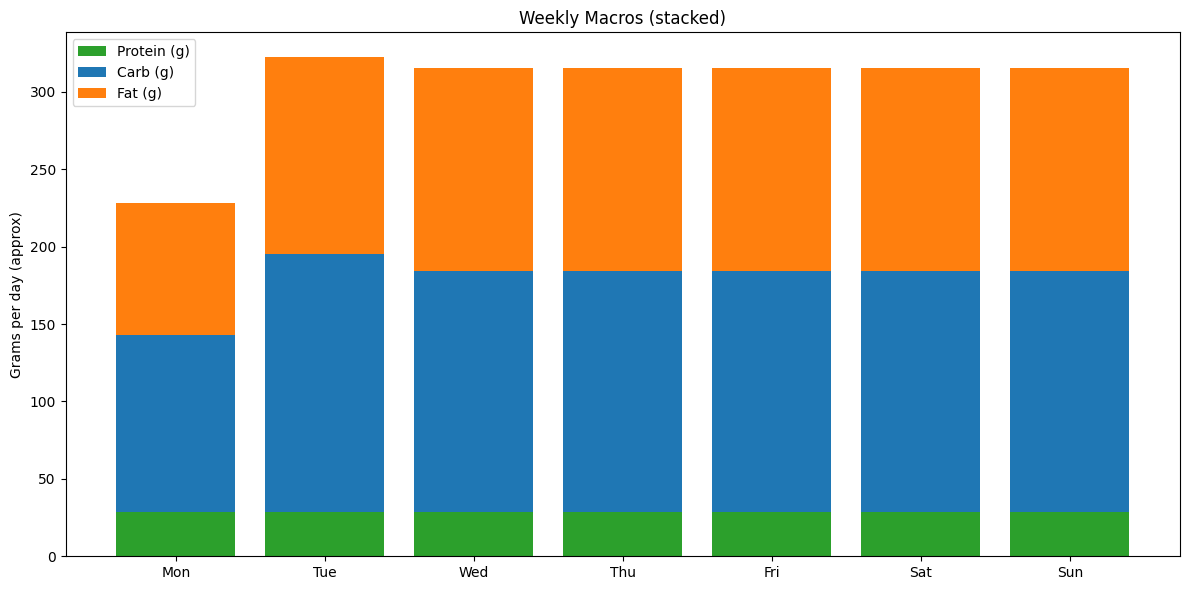

In [10]:
# Pretty display of the weekly plan
from IPython.display import display

# Style table
styler = (
    meal_plan.style
    .format({'Calories (kcal)': '{:.0f}', 'Score': '{:.3f}'})
    .set_caption('Weekly Meal Plan: 7 days, 3 meals/day')
)
# Hide index compatibly
try:
    if hasattr(styler, 'hide_index'):
        styler = styler.hide_index()
    elif hasattr(styler, 'hide'):
        styler = styler.hide(axis='index')
except Exception as e:
    print('Index hide skipped:', e)

# Highlight per-meal calories closeness
styler = styler.background_gradient(cmap='Blues', subset=['Calories (kcal)', 'Score'])

display(styler)

# Chart: stacked bar of macros per day (approx using densities * kcal target per meal)
try:
    import matplotlib.pyplot as plt
    # Aggregate by day
    agg = meal_plan.copy()
    # Approx grams by multiplying per-kcal density with meal calories
    agg['Protein (g)'] = agg['Protein/kcal'] * agg['Calories (kcal)']
    agg['Carb (g)'] = agg['Carb/kcal'] * agg['Calories (kcal)']
    agg['Fat (g)'] = agg['Fat/kcal'] * agg['Calories (kcal)']
    day_df = agg.groupby('Day')[['Protein (g)', 'Carb (g)', 'Fat (g)']].sum().reindex(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    plt.figure(figsize=(12,6))
    bottoms = None
    for col, color in [('Protein (g)', '#2ca02c'), ('Carb (g)', '#1f77b4'), ('Fat (g)', '#ff7f0e')]:
        plt.bar(day_df.index, day_df[col], bottom=bottoms, label=col, color=color)
        bottoms = day_df[col] if bottoms is None else bottoms + day_df[col]
    plt.ylabel('Grams per day (approx)')
    plt.title('Weekly Macros (stacked)')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Chart skipped:', e)

In [11]:
# Optional write outputs (CSV + JSON)
if write_outputs:
    os.makedirs(output_dir, exist_ok=True)
    csv_path = os.path.join(output_dir, 'meal_plan.csv')
    json_path = os.path.join(output_dir, 'meal_plan.json')
    meal_plan.to_csv(csv_path, index=False)
    with open(json_path, 'w') as f:
        json.dump(meal_plan.to_dict(orient='records'), f, indent=2)
    print('Saved:', csv_path, 'and', json_path)

Saved: output/MealPlan/meal_plan.csv and output/MealPlan/meal_plan.json


## Usage
1. Rulează celulele 1–4 pentru inițializare și citirea datelor.
2. În Celula 3, setează profilul (gen, vârstă, greutate, activitate), obiectivul (slăbit/masă), alergeni, likes/dislikes, pantry.
3. Rulează celulele 5–9 pentru filtre, ținte calorice/macros, scorare, assemblare plan, afișare și export.
4. Ajustează `meal_splits` și `macro_targets_by_goal` dacă dorești un alt echilibru.